In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults, load_all_results
from utils.referral_handler import ReferralHandler, ReferralResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from plotting.main_seg_results import plot_seg_erros_uncertainties
from plotting.result_plots import plot_referral_results

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 0

# baseline: 
exp_base = {3: "20180509_18_36_23_dcnn_f3_150KE_lr2e02",
            2: "20180509_18_36_28_dcnn_f2_150KE_lr2e02",
            1: "20180509_18_36_32_dcnn_f1_150KE_lr2e02",
            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
exp_base_path = os.path.join(LOG_DIR, exp_base[TEST_FOLD])


exp_mc005_brier = {3: "20180428_09_11_35_dcnn_mc_f3p005_brier_150KE_lr2e02",
                   2: "20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02",
                   1: "20180426_14_45_50_dcnn_mc_f1p005_brier_150KE_lr2e02",
                   0: "20180418_15_02_36_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_brier_path = os.path.join(LOG_DIR, exp_mc005_brier[TEST_FOLD])


# 20180508_11_47_05_dcnn_mc_f2p01_brier_20KE_lr2e02
# 20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02
exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])


In [3]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_base = ExperimentHandler.load_experiment(exp_base_path)
exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)
exper_hdl_base.set_model_name("Base DCNN fold-{} (p={})".format(
                                     exper_hdl_base.exper.run_args.fold_ids[0],
                                     exper_hdl_base.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_base.exper.model_name))


exper_mc005_brier = ExperimentHandler.load_experiment(exp_mc005_brier_path)
exper_hdl_mc005_brier = ExperimentHandler(exper_mc005_brier, use_logfile=False)
exper_hdl_mc005_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc005_brier.set_model_name("MC-dropout-brier fold-{} (p={})".format(
                                     exper_hdl_mc005_brier.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_brier.exper.model_name))


exper_mc01_brier = ExperimentHandler.load_experiment(exp_mc01_brier_path)
exper_hdl_mc01_brier = ExperimentHandler(exper_mc01_brier, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_brier.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc005_brier.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)

  0%|          | 0/25 [00:00<?, ?it/s]

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 0
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_39_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
Model name Base DCNN fold-0 (p=0.5)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_36_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-brier fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout brier fold-0 (p=0.1)
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:01<00:00, 12.95it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


In [7]:

referral_thresholds = [0.08]

ref_results_entropy = ReferralResults(exp_mc01_brier, referral_thresholds, print_results=False,
                              fold=None, slice_filter_type=None, use_entropy_maps=True)
ref_results = ReferralResults(exp_mc01_brier, referral_thresholds, print_results=False,
                              fold=None, slice_filter_type=None, use_entropy_maps=False)

INFO - Loading referral results for thresholds [0.08]
WARNING - referral positives-only=False
INFO - Loading referral results for thresholds [0.08]
WARNING - referral positives-only=False


In [9]:
from plotting.referral_stats_plots import show_referral_results

show_referral_results(ref_results_entropy, referral_threshold=0.08, per_disease=True)

----------------------Overall results for referral-threshold 0.08 ----------------------
without referral - dice(RV/Myo/LV):	ES 0.85/0.88/0.91	ED 0.92/0.86/0.96
   with referral - dice(RV/Myo/LV):	ES 0.97/0.99/0.99	ED 0.99/0.99/1.00

------------------------------ Results for class NOR ----------------------------------
ES & ED Mean/median u-value 0.00/0.00 & 0.00/0.00	 % slices referred 0.00 & 0.00
without referral - dice(RV/Myo/LV):	ES 0.87/0.91/0.93	ED 0.95/0.88/0.97
   with referral - dice(RV/Myo/LV):	ES 0.97/0.99/0.99	ED 0.99/0.99/1.00
without referral - HD (RV/Myo/LV):	ES 11.90/8.20/7.92	ED 10.17/8.05/5.44
   with referral - HD (RV/Myo/LV):	ES 6.47/3.87/3.07	ED 4.15/2.78/2.00
 
------------------------------ Results for class DCM ----------------------------------
ES & ED Mean/median u-value 0.00/0.00 & 0.00/0.00	 % slices referred 0.00 & 0.00
without referral - dice(RV/Myo/LV):	ES 0.85/0.87/0.96	ED 0.93/0.87/0.97
   with referral - dice(RV/Myo/LV):	ES 0.97/0.99/0.99	ED 0.99/0.99

In [ ]:
exper_hdl_mc01_brier.create_entropy_maps(do_save=True)

In [25]:
exper_hdl_mc01_brier.get_entropy_maps()

In [26]:
patient_id = "patient100"
entropy_map = exper_hdl_mc01_brier.entropy_maps[patient_id]
num_of_slices = entropy_map.shape[3]
num_of_phases = 2
num_of_classes= 4

cls_labels = ["BG", "RV", "MYO", "LV"]
phase_labels = ["ES", "ED"]

Min/max values 0.00/0.48
Min/max values 0.00/0.40
Min/max values 0.00/0.42
Min/max values 0.00/0.38
Min/max values 0.00/0.40
Min/max values 0.00/0.39
Min/max values 0.00/0.40
Min/max values 0.00/0.40
Min/max values 0.00/0.41
Min/max values 0.00/0.40
Min/max values 0.00/0.41
Min/max values 0.00/0.39
Min/max values 0.00/0.47
Min/max values 0.00/0.47
Min/max values 0.00/0.36
Min/max values 0.00/0.50


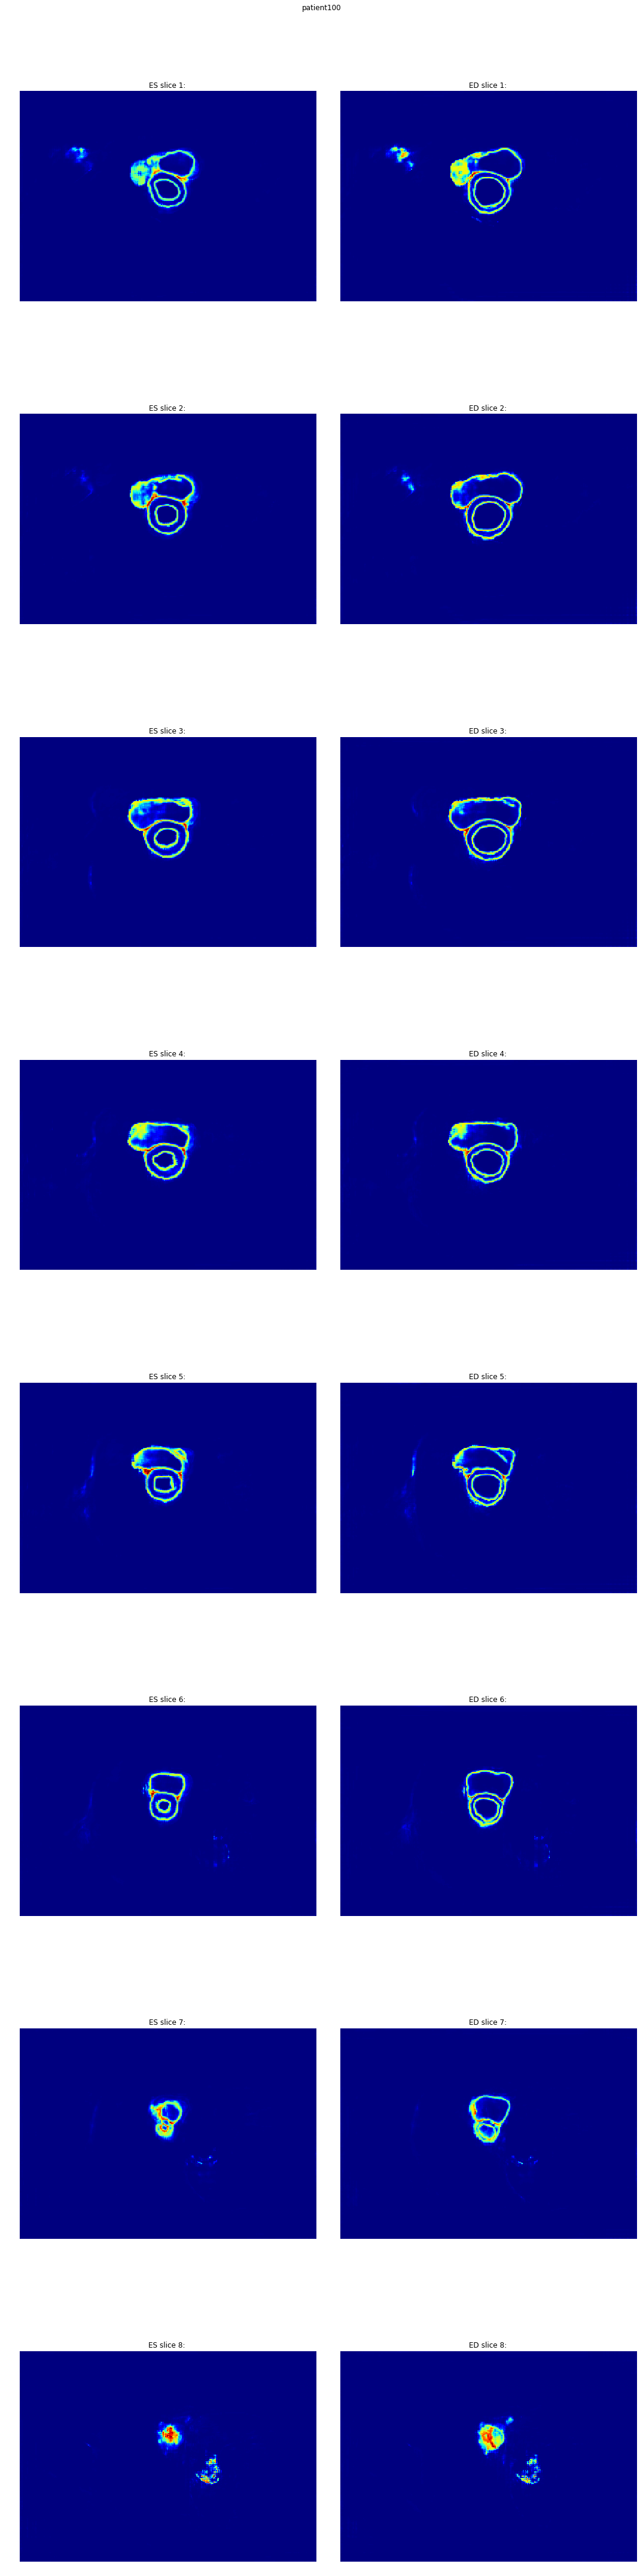

In [27]:
slice_range = np.arange(num_of_slices)

rows = 2 *  num_of_slices
columns = 4
width = 16
height = 16 * num_of_slices / 2   # num_of_classes * 2 * num_of_slices

row = 0
column = 0

fig = plt.figure(figsize=(width, height))
fig.suptitle("{}".format(patient_id))
for slice_id in slice_range:
    for phase in np.arange(2):
        cls_offset = phase * num_of_classes
        column = 0
        entropy_slice_map = entropy_map[phase, :, :, slice_id]
        print("Min/max values {:.2f}/{:.2f}".format(np.min(entropy_slice_map),
                                                    np.max(entropy_slice_map)))
        ax1 = plt.subplot2grid((rows, columns), (row, phase * 2), rowspan=2, colspan=2)
        ax1plot = ax1.imshow(entropy_slice_map, cmap="jet",
                                       vmin=0.)

        plt.axis("off")
        ax1.set_title("{} slice {}: ".format(phase_labels[phase], slice_id+1))
        
    row += 2

fig.tight_layout(rect=[0.03, 0.03, 0.97, 0.97])